In [2]:
import tensorflow as tf
import torch
import random
import os
import pathlib
import time
import datetime
import numpy as np
from matplotlib import pyplot as plt
from IPython import display
import tensorflow.keras.backend as K
from sklearn.preprocessing import OneHotEncoder
tf.config.run_functions_eagerly(True)


In [3]:
#change current directory up to parent, only run 1 time!
os.chdir("..")

In [4]:
#encoder
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

# load data

In [5]:
def load_data(test=False,Print=False,path=f'{os.path.abspath(os.curdir)}/data/carseg_data/clean_data',nr_img=1498):
    train_data_input=[]
    train_data_target=[]
    
    for n in range(nr_img):
        n1=n
        if test:
            n1=f'{n}_a'
        try:
            test1=np.load(f'{path}/{n1}.npy')
            inputs=test1[:3].transpose()
            inputs=tf.convert_to_tensor(inputs)
            inputs=inputs[tf.newaxis,...]
            target=test1[3].transpose()
            target=tf.convert_to_tensor(target)
            target=target[...,tf.newaxis]
            target=target[tf.newaxis,...]

            
            train_data_input.append(inputs)
            train_data_target.append(target)
        except:
            if Print:
                print(f'fil nr {n} mangeler')
    return [train_data_input,train_data_target]

In [6]:
test_data=load_data(test=True)
train_data=load_data()

In [7]:
def Get_stats(data):
    print(f'Number of training img {len(data[0])}')
    print(f'target sahpe {data[1][0].shape}')
    print(f'input shape {data[0][0].shape}')

print('test_data:')
Get_stats(test_data)
print('train_data:')
Get_stats(train_data)

test_data:
Number of training img 99
target sahpe (1, 256, 256, 1)
input shape (1, 256, 256, 3)
train_data:
Number of training img 1128
target sahpe (1, 256, 256, 1)
input shape (1, 256, 256, 3)


#  one hot encoder


In [8]:
depth = 8

In [9]:
test_data2=tf.one_hot(test_data[1], depth)[:,:,:,:,0,:]
train_data2=tf.one_hot(train_data[1], depth)[:,:,:,:,0,:]

In [10]:
test_data[1]=test_data2
train_data[1]=train_data2

In [11]:
print('test_data:')
Get_stats(test_data)
print('train_data:')
Get_stats(train_data)

test_data:
Number of training img 99
target sahpe (1, 256, 256, 8)
input shape (1, 256, 256, 3)
train_data:
Number of training img 1128
target sahpe (1, 256, 256, 8)
input shape (1, 256, 256, 3)


In [12]:
example_input, example_target=test_data[0][0],test_data[1][0]

In [13]:
down_model = downsample(3, 4)

In [14]:
#decoder
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [15]:
up_model = upsample(3, 4)
print(up_model)

In [16]:
def Generator():
  inputs = tf.keras.layers.Input(shape=[256, 256, 3])

  down_stack = [
    downsample(64, 2, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
    downsample(128, 3),
    downsample(128, 2),# (batch_size, 64, 64, 128)
    downsample(256, 2),  # (batch_size, 32, 32, 256)
    downsample(512, 3),  # (batch_size, 16, 16, 512)
    downsample(512, 3),  # (batch_size, 8, 8, 512)
    downsample(512, 2),  # (batch_size, 4, 4, 512)
    #downsample(512, 7),  # (batch_size, 2, 2, 512)
    #downsample(512, 7),  # (batch_size, 1, 1, 512)
  ]

  up_stack = [
    #upsample(512, 7, apply_dropout=True),  # (batch_size, 2, 2, 1024)
    #upsample(512, 7, apply_dropout=True),  # (batch_size, 4, 4, 1024)
    upsample(512, 3, apply_dropout=True),  # (batch_size, 8, 8, 1024)
    upsample(512, 2),  # (batch_size, 16, 16, 1024)
    upsample(256, 2),  # (batch_size, 32, 32, 512)
    upsample(128, 3),
    upsample(128, 2), # (batch_size, 64, 64, 256)
    upsample(64, 2),  # (batch_size, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  OUTPUT_CHANNELS=8
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')  # (batch_size, 256, 256, 3)
  softlayer=tf.keras.layers.Softmax(axis = -1)


  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)
  
  x = softlayer(x)
  #x = tf.math.argmax(x, axis = -1)[...,tf.newaxis]
  return tf.keras.Model(inputs=inputs, outputs=x)

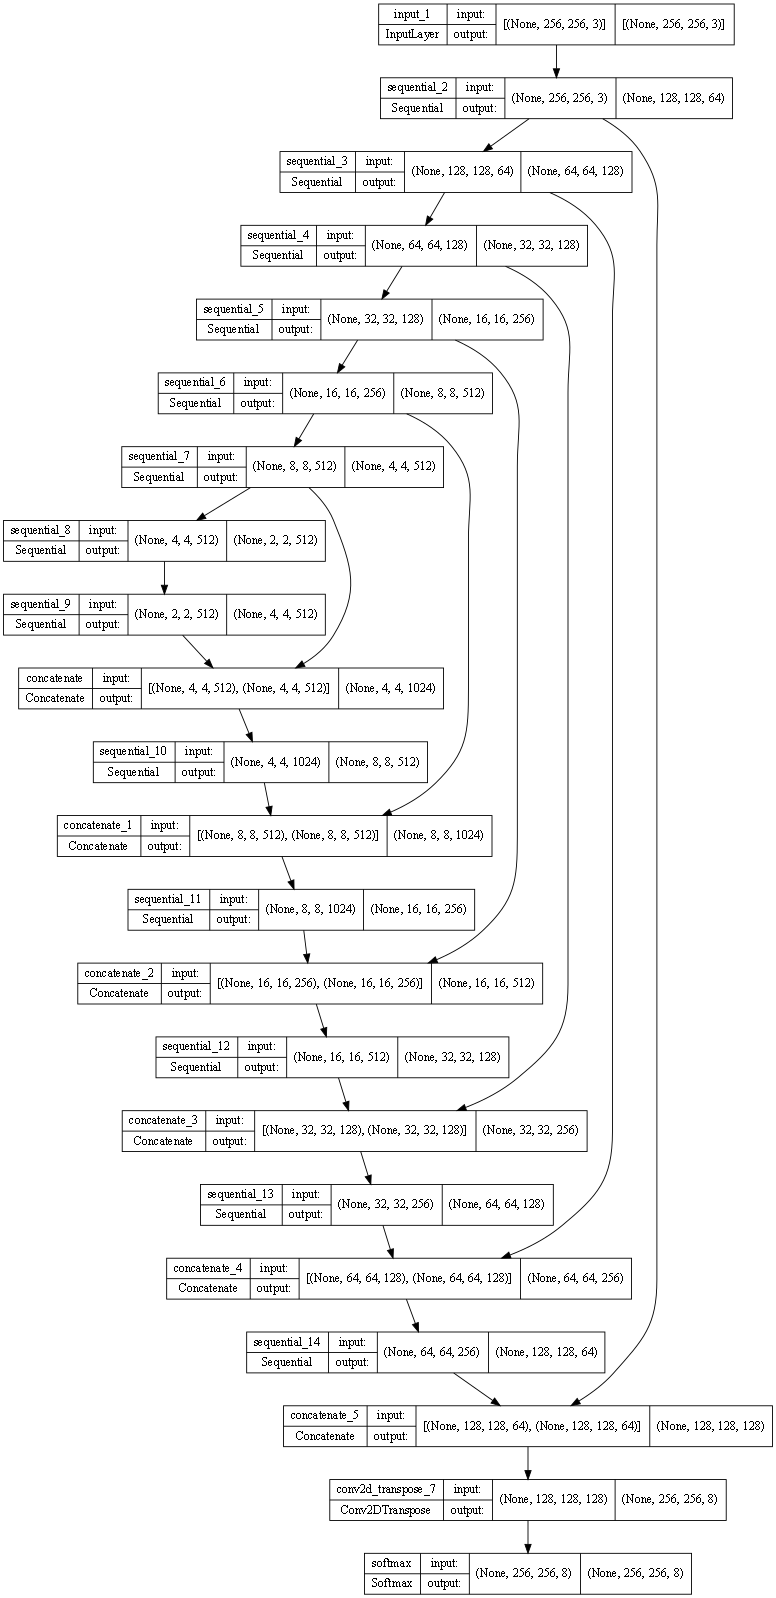

In [17]:
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

In [18]:
#print(test_data[0][0].shape)
gen_output = generator(test_data[0][0], training=False)
#print(gen_output.shape)
#gen_output = tf.math.argmax(gen_output, axis = -1)[...,tf.newaxis]
#print(gen_output.shape)
#plt.imshow(gen_output[0, ...])
#print(gen_output)

# loos

In [19]:
LAMBDA = 1

In [20]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [21]:
def dice_coef(y_true, y_pred, smooth=0):        
    y_true_f = K.flatten(y_true)
    print("y_true")
    print(y_true_f)
    y_pred_f = K.flatten(y_pred)
    print("y_pred")
    print(y_pred_f)
    intersection = K.sum(y_true_f * y_pred_f)
    print("intersection")
    print(intersection)
    dice = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return dice


In [22]:
def generator_loss(disc_generated_output, gen_output, target,gansco=0 ):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # Mean absolute error
  l1_loss=1-dice_coef(target,gen_output)

  total_gen_loss = gan_loss*gansco + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

In [23]:
def generator_loss1(disc_generated_output, gen_output,  target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)
  y_true_f = K.flatten(target)
  y_pred_f = K.flatten(gen_output)
    
  l111=(y_true_f) - (y_pred_f)
  l11=tf.abs(l111)
  l1_loss = tf.reduce_mean(l11)

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

In [24]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
  
  tar = tf.keras.layers.Input(shape=[256, 256, 8], name='target_image')
  
  x = tf.keras.layers.concatenate([inp, tar])  # (batch_size, 256, 256, channels*2)
 
  down1 = downsample(64, 4, False)(x)  # (batch_size, 128, 128, 64)
  down2 = downsample(128, 4)(down1)  # (batch_size, 64, 64, 128)
  down3 = downsample(256, 4)(down2)  # (batch_size, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (batch_size, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)  # (batch_size, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2)  # (batch_size, 30, 30, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)

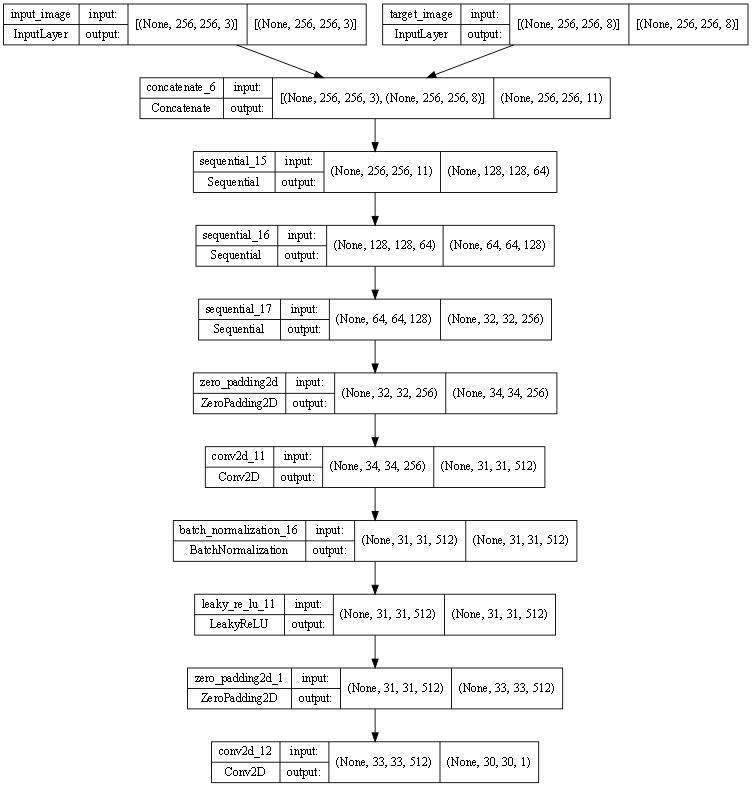

In [25]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

In [26]:
def discriminator_loss(disc_real_output, disc_generated_output):


  total_disc_loss = -dice_coef(disc_real_output,disc_generated_output)

  return total_disc_loss

In [27]:
def discriminator_loss1(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

In [28]:
generator_optimizer = tf.keras.optimizers.Adam(2e-3, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-5, beta_1=0.5)

In [29]:
def generate_images(model, test_input, tar):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15, 15))
  #print(prediction[0])
  display_list = [test_input[0], tf.argmax(tar[0],axis=-1),tf.argmax(prediction[0],axis=-1) ]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # Getting the pixel values in the [0, 1] range to plot.
    plt.imshow(display_list[i]) #* 0.5 + 0.5)
    plt.axis('off')
  plt.show()

In [30]:
def generate_loses(loses):

    plt.show
    title = ['gen_total_loss', 'gen_gan_loss', 'gen_l1_loss','disc_loss']

    for i in range(4):
        plt.subplot(2, 2, i+1)
        plt.title(title[i])
        plt.plot(loses[1:,i])
    plt.show()

In [31]:
log_dir="logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [32]:
@tf.function
def train_step(input_image, target, step,unet=True):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)
    #gen_output = tf.math.argmax(gen_output, axis = -1)[...,tf.newaxis]
    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  #discriminator_gradients = disc_tape.gradient(disc_loss,
                                               #discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  #discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              #discriminator.trainable_variables))
  losees=np.array([gen_total_loss.numpy(),gen_gan_loss.numpy(),gen_l1_loss.numpy(),disc_loss.numpy()])
  with summary_writer.as_default():
    tf.summary.scalar('gen_total_loss', gen_total_loss, step=step//1000)
    tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=step//1000)
    tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=step//1000)
    tf.summary.scalar('disc_loss', disc_loss, step=step//1000)
  return losees

In [33]:
def fit(train_ds, test_ds, steps,batch_size=4):
  randomnr=random.randint(0,len(test_ds[0])-1)
  example_input, example_target=test_ds[0][randomnr],test_data[1][randomnr]
  start = time.time()
  losees=np.array([[0,0,0,0]])
  for step in range(steps):
    r1=random.randint(0,len(train_ds[0])-1)
    input_image=train_ds[0][r1]
    target=train_ds[1][r1]
    for n in range(batch_size-1):  
        r2=random.randint(0,len(train_ds[0])-1)
        input_image2=train_ds[0][r1]
        target2=train_ds[1][r1]
        input_image=tf.concat([input_image2,input_image],0)
        target1=tf.concat([target2,target],0)
    
    if(step) % 10 == 0:
      display.clear_output(wait=True)

      if step != 0:
        print(f'Time taken for 10 steps: {time.time()-start:.2f} sec\n')
        #print(losees)

      start = time.time()

      generate_images(generator, example_input, example_target)
      generate_loses(losees)
      print(f"Step: {step//1000}0")
    l=train_step(input_image, target, step)
    losees=np.append(losees,np.array([l]),axis=0)  
      
  
    # Training step
    if (step+1) % 10 == 0:
      print('.', end='', flush=True)


    # Save (checkpoint) the model every 5k steps
    #if (step + 1) % 5000 == 0:
      #checkpoint.save(file_prefix=checkpoint_prefix)

In [53]:
r1=random.randint(0,len(train_data[0])-1)
input_image=train_data[0][r1]
target=train_data[1][r1]
for n in range(100-1):  
    r2=random.randint(0,len(train_data[0])-1)
    input_image2=train_data[0][r1]
    target2=train_data[1][r1]
    input_image=tf.concat([input_image2,input_image],0)
    target1=tf.concat([target2,target],0)
print(input_image.shape)

(100, 256, 256, 3)


Time taken for 10 steps: 10.06 sec



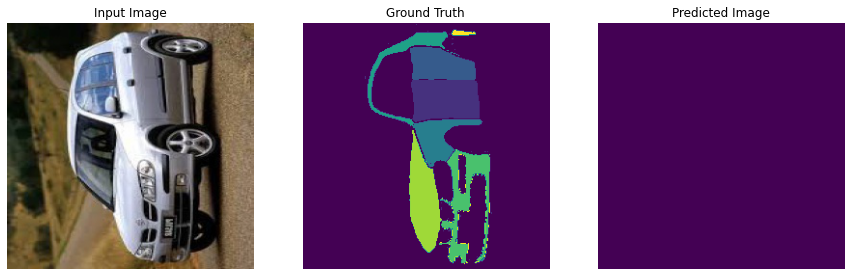

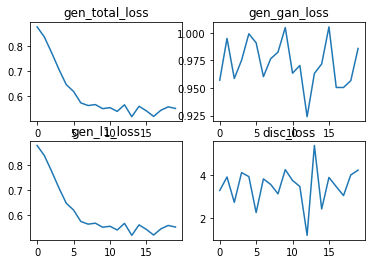

Step: 00
y_true
tf.Tensor([1. 0. 0. ... 0. 0. 0.], shape=(524288,), dtype=float32)
y_pred
tf.Tensor([0.3269777  0.094022   0.09257712 ... 0.086618   0.08157526 0.09827854], shape=(524288,), dtype=float32)
intersection
tf.Tensor(30016.594, shape=(), dtype=float32)
y_true
tf.Tensor(
[-1.83494538e-02  5.65303981e-01  7.33721197e-01  1.77107543e-01
  4.11040366e-01  3.51875484e-01  5.02474010e-01  4.83128816e-01
  5.12400389e-01  8.58653307e-01  4.03338671e-01 -1.09876484e-01
 -2.90981829e-01 -3.80459994e-01 -9.01896477e-01 -1.40081674e-01
 -3.97816420e-01 -4.55055952e-01 -1.93807349e-01 -6.67381167e-01
 -2.78956652e-01 -4.34783906e-01 -1.54921576e-01 -3.15802455e-01
 -3.56648952e-01 -3.38972121e-01 -3.86736095e-01 -8.29871416e-01
 -2.30791837e-01 -3.96504343e-01 -4.49646950e-01  2.60533929e-01
 -1.36795044e-02 -2.05682993e-01  2.49391198e-02 -1.49255097e-02
  3.16998214e-01  3.27610314e-01  2.90594220e-01  1.11714840e-01
  1.79601192e-01 -5.38593292e-01 -3.86197954e-01 -6.90534949e-01
 -9

y_true
tf.Tensor([1. 0. 0. ... 0. 0. 0.], shape=(524288,), dtype=float32)
y_pred
tf.Tensor([0.38200015 0.08674495 0.08676567 ... 0.08560513 0.08072842 0.0967527 ], shape=(524288,), dtype=float32)
intersection
tf.Tensor(29917.742, shape=(), dtype=float32)
y_true
tf.Tensor(
[ 5.88602781e-01  1.06142378e+00  4.70654488e-01  8.33663523e-01
  6.49698079e-03  1.97707713e-02  6.17090464e-02 -1.30352885e-01
  3.35054517e-01 -1.98340416e-02  1.22487843e-02  2.11651921e-02
  4.53353763e-01  2.17793882e-01 -6.90420032e-01 -7.90697336e-03
  6.10954762e-02 -1.17393899e+00 -2.00609660e+00 -5.40656924e-01
 -4.53698516e-01  3.92901897e-02  1.91040576e-01 -1.27293527e-01
 -7.62633979e-02 -1.55147165e-01 -2.99361587e-01 -3.91585201e-01
  8.55801046e-01  1.40187338e-01  1.21583414e+00  7.37063706e-01
 -5.80945849e-01  2.75544882e-01  4.54647064e-01  5.39035857e-01
  6.72199428e-02  2.89205581e-01  7.04697013e-01  8.22115123e-01
  2.32347563e-01  8.96249175e-01  3.18332106e-01 -6.62720859e-01
 -3.93586040

y_true
tf.Tensor([1. 0. 0. ... 0. 0. 0.], shape=(524288,), dtype=float32)
y_pred
tf.Tensor([0.36416546 0.08836027 0.08844294 ... 0.07888242 0.07497352 0.08941557], shape=(524288,), dtype=float32)
intersection
tf.Tensor(30151.281, shape=(), dtype=float32)
y_true
tf.Tensor(
[-1.43117309e-02  4.27803308e-01  1.49906278e-01  7.97460973e-02
  7.97390342e-02  8.49612951e-02  7.40904808e-02  7.89432377e-02
  7.49550760e-02 -8.64977688e-02  6.95695996e-01  1.86771739e+00
  2.30043483e+00  4.22021341e+00  2.30959105e+00  3.10749578e+00
 -3.49214643e-01  2.96144485e-02  1.81590033e+00  8.24411929e-01
  2.43009877e+00  1.15388656e+00 -1.20900905e+00 -1.25533402e+00
 -4.48187351e-01 -1.40606701e-01  1.57117450e+00  7.71130681e-01
 -9.87105489e-01  3.33372176e-01  6.36633754e-01  1.15874052e+00
  5.56328535e-01  3.87836039e-01  3.93731952e-01  3.85912120e-01
  3.83748889e-01  3.92515600e-01  4.02549684e-01  3.91477197e-01
  9.17727888e-01  3.19940138e+00  3.75197148e+00  4.54132318e+00
  1.33471346

y_true
tf.Tensor([1. 0. 0. ... 0. 0. 0.], shape=(524288,), dtype=float32)
y_pred
tf.Tensor([0.3962839  0.08504604 0.08502708 ... 0.08278684 0.07829366 0.09346014], shape=(524288,), dtype=float32)
intersection
tf.Tensor(28684.559, shape=(), dtype=float32)
y_true
tf.Tensor(
[ 1.14785576e+00  1.10155964e+00  1.04857135e+00  8.87671411e-01
  6.57715678e-01  5.46338797e-01  2.45900393e-01 -4.34393883e-02
 -1.22279644e-01 -5.96650660e-01 -3.36626053e-01 -4.01773810e-01
 -3.58102322e-01  1.66918740e-01 -5.67469001e-02  9.00029898e-01
 -3.32943380e-01  2.24874115e+00  1.96130240e+00  1.90480804e+00
  1.60153079e+00  1.05088532e+00  8.93887877e-01  6.39348269e-01
  4.48149502e-01  4.97053742e-01  2.13136971e-02 -3.36671770e-01
  3.36151093e-01 -2.09827617e-01  1.68078220e+00  1.58059990e+00
  9.92182910e-01  1.02592969e+00  9.92596984e-01  1.09344006e+00
  2.23974168e-01  4.52175975e-01  8.83894920e-01 -3.47112060e-01
 -6.81503236e-01 -7.46903777e-01  1.34327531e+00  1.14346266e-01
  8.17859650

y_true
tf.Tensor([1. 0. 0. ... 0. 0. 0.], shape=(524288,), dtype=float32)
y_pred
tf.Tensor([0.4233869  0.08116664 0.08120044 ... 0.08385296 0.07992867 0.09517414], shape=(524288,), dtype=float32)
intersection
tf.Tensor(29854.76, shape=(), dtype=float32)
y_true
tf.Tensor(
[-4.55450892e-01 -4.64102030e-02  1.20334136e+00  3.34351629e-01
  2.51523352e+00  4.43454832e-01  6.52277827e-01  1.82526731e+00
  3.80030006e-01 -1.50000548e+00 -9.98459578e-01 -3.89537215e-02
 -9.77010012e-01  1.67883366e-01 -1.27270997e+00  4.09315109e-01
  2.55244493e-01 -1.13145161e+00  7.58715928e-01  2.73524523e-01
  4.88771796e-02  2.88252771e-01  1.42850816e-01  1.80411845e-01
  1.68600693e-01  1.05301999e-01  2.32955992e-01 -2.11523473e-01
  2.27587163e-01 -1.47961080e-01  3.38586688e-01  1.65910244e-01
  5.32495499e-01 -9.04725730e-01  4.70208764e-01 -7.42932558e-02
  5.63360989e-01  2.27437520e+00  5.82637310e-01 -5.51947057e-02
  1.39833808e-01  2.22782493e-01 -2.29668069e+00 -1.66482663e+00
 -1.84070551e

y_true
tf.Tensor([1. 0. 0. ... 0. 0. 0.], shape=(524288,), dtype=float32)
y_pred
tf.Tensor([0.3160833  0.09633634 0.0952668  ... 0.08467451 0.0804884  0.09527752], shape=(524288,), dtype=float32)
intersection
tf.Tensor(30490.234, shape=(), dtype=float32)
y_true
tf.Tensor(
[-1.37750298e-01  6.34849548e-01 -3.20534527e-01 -1.82142198e-01
 -3.07370603e-01  9.72290576e-01  7.94041157e-01  1.25391614e+00
  1.57454467e+00  1.05433452e+00  2.09722471e+00  1.57831430e+00
  1.58190572e+00  7.52703965e-01  2.17192963e-01  7.46439874e-01
 -6.51366591e-01 -6.29108787e-01 -6.08481586e-01  7.72870362e-01
 -1.31220102e-01 -2.25907922e-01 -1.30632490e-01 -8.56589377e-02
 -7.94385672e-02  9.84956473e-02  2.06921205e-01 -4.46466804e-02
  7.02904761e-02 -6.05685413e-02 -6.55992985e-01  7.11645603e-01
 -3.97717565e-01  4.57878858e-01  7.17601359e-01  1.56974816e+00
  1.47058988e+00  1.58413875e+00  1.68206012e+00  1.67914605e+00
  2.78942537e+00  2.62683225e+00  7.82876492e-01 -4.89882112e-01
 -7.10626125

KeyboardInterrupt: 

In [34]:
fit(train_data, test_data, steps=1000)

In [ ]:
[1,2,3]*[2,2,2]

In [ ]:
c = tf.constant([1.0, 0.0,0.0])
d = tf.constant([0.9, 0.3,0.3])
1-K.sum(c*d)